## Dependencies

In [1]:
import pandas
%pip install pandas
%pip install fastparquet
%pip install tensorflow
%pip install matplotlib
%pip install numpy
%pip install keras
%pip install pydot


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


## Setup

In [2]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
import wandb
from wandb.keras import WandbCallback

## Import and preprocess data

In [3]:
df = pd.read_parquet("data/Thermo_SRM_Pool_meta_data.parquet", engine='fastparquet')

In [4]:
print(df.shape)
print(df.head(4))
print(df.columns)

(6080606, 15)
                                       raw_file  scan_number  \
0  01640c_BC1-Thermo_SRM_Pool_3_01_01-DDA-1h-R2        34736   
1  01640c_BC1-Thermo_SRM_Pool_3_01_01-DDA-1h-R2        25591   
2  01640c_BC1-Thermo_SRM_Pool_3_01_01-DDA-1h-R2        24831   
3  01640c_BC1-Thermo_SRM_Pool_3_01_01-DDA-1h-R2        34870   

      modified_sequence  precursor_charge  precursor_intensity          mz  \
0  LPGSLETYVEQEQGENANDR                 2           29525630.0  1125.01950   
1       HGSLQEYLQNDTGSK                 2           13188580.0   838.89737   
2        VEEEEEINSELTAR                 2           20663460.0   824.38904   
3  LPGSLETYVEQEQGENANDR                 2           19884630.0  1125.01950   

   precursor_mz fragmentation mass_analyzer  retention_time  \
0   1125.018331           CID          ITMS          38.411   
1    838.894401           HCD          FTMS          30.394   
2    824.388401           CID          ITMS          29.737   
3   1125.018831       

### Check what charge states are in the data

In [5]:
list_charge = df["precursor_charge"].unique().tolist()
print(sorted(list_charge))

[1, 2, 3, 4, 5, 6, 7]


### Create dataframe containing only sequence and precursor charge

In [6]:
# drop all columns we don't need for training
for column in df.columns:
    if column not in ["modified_sequence", "precursor_charge"]:
        df.drop(column, axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6080606 entries, 0 to 6080605
Data columns (total 2 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   modified_sequence  object
 1   precursor_charge   int64 
dtypes: int64(1), object(1)
memory usage: 92.8+ MB


### Remove all sequences containing '[UNIMOD:'

In [7]:
def delete_entries_with_partial_string(dataframe, column_name, partial_string):
    escaped_string = re.escape(partial_string)
    dataframe = dataframe[~dataframe[column_name].str.contains(escaped_string)]
    return dataframe

In [8]:
df_filtered = delete_entries_with_partial_string(df, 'modified_sequence', '[UNIMOD:')
df_filtered

,modified_sequence,precursor_charge
0,LPGSLETYVEQEQGENANDR,2
1,HGSLQEYLQNDTGSK,2
2,VEEEEEINSELTAR,2
3,LPGSLETYVEQEQGENANDR,2
4,NSSTAEINETTTSSTDFLAR,2
...,...,...
6080594,HGIGSLLLESLK,3
6080599,ALEAENSALALENENQR,2
6080600,ALEAENSALALENENQR,2
6080603,EMENFVQSSGEDGIVVFSLGSLFQNVTEEK,3


### Convert protein sequences to numerical representation

In [9]:
amino_acids = list('ACDEFGHIKLMNPQRSTVWY')  # List of amino acids

def sequence_to_vector(sequence):
    vector = []
    for amino_acid in sequence:
        if amino_acid in amino_acids:
            vector.append(amino_acids.index(amino_acid))
        else:
            vector.append(len(amino_acids))  # Handle unknown amino acids
    return vector

df_filtered['sequence_vector'] = df_filtered['modified_sequence'].apply(sequence_to_vector)
df_filtered

C:\Users\Florian\AppData\Local\Temp\ipykernel_19648\2493357873.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sequence_vector'] = df_filtered['modified_sequence'].apply(sequence_to_vector)


,modified_sequence,precursor_charge,sequence_vector
0,LPGSLETYVEQEQGENANDR,2,"[9, 12, 5, 15, 9, 3, 16, 19, 17, 3, 13, 3, 13,..."
1,HGSLQEYLQNDTGSK,2,"[6, 5, 15, 9, 13, 3, 19, 9, 13, 11, 2, 16, 5, ..."
2,VEEEEEINSELTAR,2,"[17, 3, 3, 3, 3, 3, 7, 11, 15, 3, 9, 16, 0, 14]"
3,LPGSLETYVEQEQGENANDR,2,"[9, 12, 5, 15, 9, 3, 16, 19, 17, 3, 13, 3, 13,..."
4,NSSTAEINETTTSSTDFLAR,2,"[11, 15, 15, 16, 0, 3, 7, 11, 3, 16, 16, 16, 1..."
...,...,...,...
6080594,HGIGSLLLESLK,3,"[6, 5, 7, 5, 15, 9, 9, 9, 3, 15, 9, 8]"
6080599,ALEAENSALALENENQR,2,"[0, 9, 3, 0, 3, 11, 15, 0, 9, 0, 9, 3, 11, 3, ..."
6080600,ALEAENSALALENENQR,2,"[0, 9, 3, 0, 3, 11, 15, 0, 9, 0, 9, 3, 11, 3, ..."
6080603,EMENFVQSSGEDGIVVFSLGSLFQNVTEEK,3,"[3, 10, 3, 11, 4, 17, 13, 15, 15, 5, 3, 2, 5, ..."


### Pad sequence_vectors to the max sequence length

In [10]:
def pad_sequences(dataframe, column_name, pad_value=21):
    max_length = max(dataframe.loc[:, column_name].apply(len))  # Find the maximum length
    dataframe.loc[:, column_name] = dataframe.loc[:, column_name].apply(lambda x: x + [pad_value] * (max_length - len(x)))  # Pad the sequences
    return dataframe

In [11]:
df_filtered_padded = pad_sequences(df_filtered, 'sequence_vector')
df_filtered_padded

C:\Users\Florian\AppData\Local\Temp\ipykernel_19648\1913829432.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, column_name] = dataframe.loc[:, column_name].apply(lambda x: x + [pad_value] * (max_length - len(x)))  # Pad the sequences


,modified_sequence,precursor_charge,sequence_vector
0,LPGSLETYVEQEQGENANDR,2,"[9, 12, 5, 15, 9, 3, 16, 19, 17, 3, 13, 3, 13,..."
1,HGSLQEYLQNDTGSK,2,"[6, 5, 15, 9, 13, 3, 19, 9, 13, 11, 2, 16, 5, ..."
2,VEEEEEINSELTAR,2,"[17, 3, 3, 3, 3, 3, 7, 11, 15, 3, 9, 16, 0, 14..."
3,LPGSLETYVEQEQGENANDR,2,"[9, 12, 5, 15, 9, 3, 16, 19, 17, 3, 13, 3, 13,..."
4,NSSTAEINETTTSSTDFLAR,2,"[11, 15, 15, 16, 0, 3, 7, 11, 3, 16, 16, 16, 1..."
...,...,...,...
6080594,HGIGSLLLESLK,3,"[6, 5, 7, 5, 15, 9, 9, 9, 3, 15, 9, 8, 21, 21,..."
6080599,ALEAENSALALENENQR,2,"[0, 9, 3, 0, 3, 11, 15, 0, 9, 0, 9, 3, 11, 3, ..."
6080600,ALEAENSALALENENQR,2,"[0, 9, 3, 0, 3, 11, 15, 0, 9, 0, 9, 3, 11, 3, ..."
6080603,EMENFVQSSGEDGIVVFSLGSLFQNVTEEK,3,"[3, 10, 3, 11, 4, 17, 13, 15, 15, 5, 3, 2, 5, ..."


### Calculate weights to correct for class imbalance
- Count occurrences for each charge state in the dataset
- Calculate bias for binary prediction
    - class with only precursor charge 2
    - class with every other precursor charge

In [12]:
df_SingleCharges = df_filtered_padded[df_filtered_padded['precursor_charge'] == 1].copy()
df_DoubleCharges = df_filtered_padded[df_filtered_padded['precursor_charge'] == 2].copy()
df_TripleCharges = df_filtered_padded[df_filtered_padded['precursor_charge'] == 3].copy()
df_QuadrupleCharges = df_filtered_padded[df_filtered_padded['precursor_charge'] == 4].copy()
df_QuintupleCharges = df_filtered_padded[df_filtered_padded['precursor_charge'] == 5].copy()
df_SextupleCharges = df_filtered_padded[df_filtered_padded['precursor_charge'] == 6].copy()
df_SeptupleCharges = df_filtered_padded[df_filtered_padded['precursor_charge'] == 7].copy()
# other charges than 2
df_OtherCharges = df_filtered_padded[df_filtered_padded['precursor_charge'] != 2].copy()

In [13]:
CLASS_NAMES = ["DoubleCharge", "OtherCharges"]

In [15]:
COUNT_SingleCharges = len(df_SingleCharges)
COUNT_DoubleCharges = len(df_DoubleCharges)
COUNT_TripleCharges = len(df_TripleCharges)
COUNT_QuadrupleCharges = len(df_QuadrupleCharges)
COUNT_QuintupleCharges = len(df_QuintupleCharges)
COUNT_SextupleCharges = len(df_SingleCharges)
COUNT_SeptupleCharges = len(df_SeptupleCharges)
COUNT_OtherCharges = len(df_OtherCharges)

print("COUNT_SingleCharge: {}".format(COUNT_SingleCharges))
print("COUNT_DoubleCharge: {}".format(COUNT_DoubleCharges))
print("COUNT_TripleCharges:  {}".format(COUNT_TripleCharges))
print("COUNT_QuadrupleCharges: {}".format(COUNT_QuadrupleCharges))
print("COUNT_QuintupleCharges: {}".format(COUNT_QuintupleCharges))
print("COUNT_SextupleCharges: {}".format(COUNT_SextupleCharges))
print("COUNT_SeptupleCharges: {}".format(COUNT_SeptupleCharges))

COUNT_SingleCharge: 999
COUNT_DoubleCharge: 3486981
COUNT_TripleCharges:  1185177
COUNT_QuadrupleCharges: 86471
COUNT_QuintupleCharges: 1694
COUNT_SextupleCharges: 999
COUNT_SeptupleCharges: 1


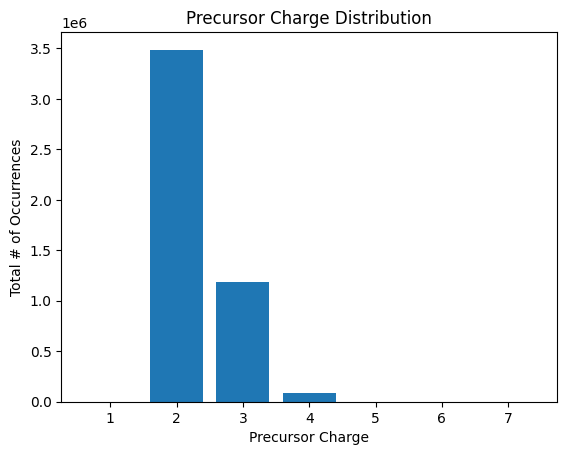

In [19]:
charge_counts = [COUNT_SingleCharges, COUNT_DoubleCharges, COUNT_TripleCharges, COUNT_QuadrupleCharges, COUNT_QuintupleCharges, COUNT_SextupleCharges, COUNT_SeptupleCharges]
charge_labels = ['1', '2', '3', '4', '5', '6', '7']
plt.bar(charge_labels, charge_counts)
plt.title('Precursor Charge Distribution')
plt.xlabel('Precursor Charge')
plt.ylabel('Total # of Occurrences')
plt.show()

In [15]:
initial_bias = np.log([COUNT_DoubleCharges / COUNT_OtherCharges])
print("Initial bias: {:.5f}".format(initial_bias[0]))

TRAINING_COUNT = COUNT_DoubleCharges + COUNT_OtherCharges
weight_for_other = (1 / COUNT_OtherCharges) * TRAINING_COUNT / 2.0
weight_for_double = (1 / COUNT_DoubleCharges) * TRAINING_COUNT / 2.0

print("weight for Double Charge: {:.2f}".format(weight_for_double))
print("weight for Other Charges: {:.2f}".format(weight_for_other))

Initial bias: 1.00652
weight for Double Charge: 0.68
weight for Other Charges: 1.87


In [16]:
# Initialize Weights and Biases
# wandb.init(project='precursor_charge_prediction')

In [ ]:
# Split data into training and testing sets
X = np.array(df_filtered_padded['sequence_vector'].tolist())
y = np.array(df_filtered_padded['precursor_charge'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define model
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=22, output_dim=16, input_length=X.shape[1]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Configure Weights and Biases callback
checkpoint_callback = ModelCheckpoint('precursor_charge_prediction_model_v1/best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
# wandb_callback = WandbCallback()

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test),
          callbacks=[checkpoint_callback]) # , wandb_callback])

# Load the best model
best_model = tf.keras.models.load_model('precursor_charge_prediction_model_v1/best_model.h5')

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_test, y_test)
print('Accuracy:', accuracy)

# Save the best model to Weights and Biases
# wandb.save('best_model.h5')


Epoch 1/10
119036/119036 [==============================] - 247s 2ms/step - loss: 0.2898 - accuracy: 0.8642 - val_loss: 0.2780 - val_accuracy: 0.8698
Epoch 2/10
119036/119036 [==============================] - 230s 2ms/step - loss: 0.2710 - accuracy: 0.8720 - val_loss: 0.2667 - val_accuracy: 0.8727
Epoch 3/10
119036/119036 [==============================] - 231s 2ms/step - loss: 0.2660 - accuracy: 0.8739 - val_loss: 0.2636 - val_accuracy: 0.8744
Epoch 4/10
119036/119036 [==============================] - 235s 2ms/step - loss: 0.2637 - accuracy: 0.8748 - val_loss: 0.2641 - val_accuracy: 0.8743
Epoch 5/10
119036/119036 [==============================] - 237s 2ms/step - loss: 0.2625 - accuracy: 0.8751 - val_loss: 0.2656 - val_accuracy: 0.8731
Epoch 6/10
119036/119036 [==============================] - 231s 2ms/step - loss: 0.2609 - accuracy: 0.8758 - val_loss: 0.2626 - val_accuracy: 0.8754
Epoch 10/10
114753/119036 [===========================>..] - ETA: 7s - loss: 0.2605 - accuracy: 0.87

In [ ]:
best_model.save('precursor_charge_prediction_model_v1')

## Testing the model
- Generate some random sequences
- run them through the model

In [ ]:
# Generate random peptide sequences
num_sequences = 10  # Number of sequences to generate
max_length = 20  # Maximum sequence length
sequences = []
for _ in range(num_sequences):
    length = random.randint(1, max_length)
    sequence = ''.join(random.choices(amino_acids, k=length))
    sequences.append(sequence)

In [42]:
# Convert peptide sequences to numerical representation
def sequence_to_vector(sequence):
    vector = []
    for amino_acid in sequence:
        if amino_acid in amino_acids:
            vector.append(amino_acids.index(amino_acid))
        else:
            vector.append(len(amino_acids))  # Handle unknown amino acids
    return np.array(vector)

# Convert the generated sequences to numerical representation
sequence_vectors = np.array([sequence_to_vector(seq) for seq in sequences])

# Load the trained model
model = tf.keras.models.load_model('precursor_charge_prediction_model_v1')  # Replace with the path to your trained model

# Predict precursor charge for the generated sequences
predictions = model.predict(sequence_vectors)
predicted_charge = np.argmax(predictions, axis=1) + 1

# Display the generated sequences and predicted precursor charge
for sequence, charge in zip(sequences, predicted_charge):
    print('Sequence:', sequence)
    print('Predicted Charge:', charge)
    print('-------------------')

### Split data into training and validation sets

In [36]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('precursor_charge')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [38]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

,modified_sequence,precursor_charge
0,LPGSLETYVEQEQGENANDR,2
1,HGSLQEYLQNDTGSK,2
2,VEEEEEINSELTAR,2
3,LPGSLETYVEQEQGENANDR,2
4,NSSTAEINETTTSSTDFLAR,2
...,...,...
6080594,HGIGSLLLESLK,3
6080599,ALEAENSALALENENQR,2
6080600,ALEAENSALALENENQR,2
6080603,EMENFVQSSGEDGIVVFSLGSLFQNVTEEK,3


In [27]:
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

C:\Users\Florian\AppData\Local\Temp\ipykernel_20888\1101443115.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sequence_vector'] = df_filtered['modified_sequence'].apply(sequence_to_vector)


In [39]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

C:\Users\Florian\AppData\Local\Temp\ipykernel_20888\1548762500.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sequence_vector'] = df_filtered['modified_sequence'].apply(sequence_to_vector)


,modified_sequence,precursor_charge,sequence_vector
0,LPGSLETYVEQEQGENANDR,2,"[9, 12, 5, 15, 9, 3, 16, 19, 17, 3, 13, 3, 13,..."
1,HGSLQEYLQNDTGSK,2,"[6, 5, 15, 9, 13, 3, 19, 9, 13, 11, 2, 16, 5, ..."
2,VEEEEEINSELTAR,2,"[17, 3, 3, 3, 3, 3, 7, 11, 15, 3, 9, 16, 0, 14]"
3,LPGSLETYVEQEQGENANDR,2,"[9, 12, 5, 15, 9, 3, 16, 19, 17, 3, 13, 3, 13,..."
4,NSSTAEINETTTSSTDFLAR,2,"[11, 15, 15, 16, 0, 3, 7, 11, 3, 16, 16, 16, 1..."
...,...,...,...
6080594,HGIGSLLLESLK,3,"[6, 5, 7, 5, 15, 9, 9, 9, 3, 15, 9, 8]"
6080599,ALEAENSALALENENQR,2,"[0, 9, 3, 0, 3, 11, 15, 0, 9, 0, 9, 3, 11, 3, ..."
6080600,ALEAENSALALENENQR,2,"[0, 9, 3, 0, 3, 11, 15, 0, 9, 0, 9, 3, 11, 3, ..."
6080603,EMENFVQSSGEDGIVVFSLGSLFQNVTEEK,3,"[3, 10, 3, 11, 4, 17, 13, 15, 15, 5, 3, 2, 5, ..."


In [23]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of sequences:', train_features['modified_sequence'])
print('A batch of precursor charges:', label_batch )

In [40]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [41]:
# from keras import layers
#
# test_type_col = train_features['modified_sequence']
# test_type_layer = get_category_encoding_layer(name='modified_sequence',
#                                               dataset=train_ds,
#                                               dtype='string')
# test_type_layer(test_type_col)

C:\Users\Florian\AppData\Local\Temp\ipykernel_20888\3823474037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, column_name] = dataframe.loc[:, column_name].apply(lambda x: np.pad(x, (0, max_length - len(x)), 'constant'))  # Pad the sequences


,modified_sequence,precursor_charge,sequence_vector
0,LPGSLETYVEQEQGENANDR,2,"[9, 12, 5, 15, 9, 3, 16, 19, 17, 3, 13, 3, 13,..."
1,HGSLQEYLQNDTGSK,2,"[6, 5, 15, 9, 13, 3, 19, 9, 13, 11, 2, 16, 5, ..."
2,VEEEEEINSELTAR,2,"[17, 3, 3, 3, 3, 3, 7, 11, 15, 3, 9, 16, 0, 14..."
3,LPGSLETYVEQEQGENANDR,2,"[9, 12, 5, 15, 9, 3, 16, 19, 17, 3, 13, 3, 13,..."
4,NSSTAEINETTTSSTDFLAR,2,"[11, 15, 15, 16, 0, 3, 7, 11, 3, 16, 16, 16, 1..."
...,...,...,...
6080594,HGIGSLLLESLK,3,"[6, 5, 7, 5, 15, 9, 9, 9, 3, 15, 9, 8, 0, 0, 0..."
6080599,ALEAENSALALENENQR,2,"[0, 9, 3, 0, 3, 11, 15, 0, 9, 0, 9, 3, 11, 3, ..."
6080600,ALEAENSALALENENQR,2,"[0, 9, 3, 0, 3, 11, 15, 0, 9, 0, 9, 3, 11, 3, ..."
6080603,EMENFVQSSGEDGIVVFSLGSLFQNVTEEK,3,"[3, 10, 3, 11, 4, 17, 13, 15, 15, 5, 3, 2, 5, ..."


In [15]:
batch_size = 1024
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

C:\Users\micro\AppData\Local\Temp\ipykernel_38360\2125574374.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
C:\Users\micro\AppData\Local\Temp\ipykernel_38360\2125574374.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
C:\Users\micro\AppData\Local\Temp\ipykernel_38360\2125574374.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [43]:
all_inputs = []
encoded_features = []

In [44]:
from keras import layers

num_col = tf.keras.Input(shape=(1,), name='precursor_charge', dtype='int64')

encoding_layer = get_category_encoding_layer(name='precursor_charge',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
encoded_num_col = encoding_layer(num_col)
all_inputs.append(num_col)
encoded_features.append(encoded_num_col)

In [45]:
categorical_cols = ['modified_sequence']

for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

COUNT_DoubleCharge: 3486981
COUNT_OtherCharges: 1274451


In [46]:
all_inputs

Initial bias: 1.00652
weight for Double Charge: 0.68
weight for Other Charges: 1.87


build model

In [18]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

In [19]:
model.compile(optimizer="adam",
              loss ="binary_crossentropy", # todo categorical_crossentropy for multiclass instead of binary
              metrics=["accuracy"])

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 precursor_charge (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 modified_sequence (InputLayer)  [(None, 1)]         0           []                               
                                                                                                  
 integer_lookup (IntegerLookup)  (None, 1)           0           ['precursor_charge[0][0]']       
                                                                                                  
 string_lookup (StringLookup)   (None, 1)            0           ['modified_sequence[0][0]']      
                                                                                              

In [21]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


KeyboardInterrupt



In [ ]:
epochs = 1
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

In [ ]:
model.save('my_charge_classifier_binary')
reloaded_model = tf.keras.models.load_model('my_charge_classifier_binary')

In [ ]:
sequence = 'AA'
charge = 2

sample = {
    'modified_sequence': sequence,
    'precursor_charge': charge,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    f"This particular Sequence '{sequence}' had a %.1f percent probability "
    f"of being of charge {charge}." % (100 * prob)
)

In [78]:
grouped = df_train.groupby("precursor_charge")
gp_dataframes = {}
for name, group in grouped:
    gp_dataframes[name] = group.copy()

In [81]:
gp_dataframes

{1:            modified_sequence  precursor_charge
 5982              YGVSITLSGR                 1
 7622              GSTESSVFLR                 1
 19617             GSYMEVEDNR                 1
 21051             GSYMEVEDNR                 1
 25096               AGEIVVFK                 1
 ...                      ...               ...
 6052827  C[UNIMOD:4]LGHYVNGK                 1
 6052845  C[UNIMOD:4]LGHYVNGK                 1
 6052855  C[UNIMOD:4]LGHYVNGK                 1
 6052859  C[UNIMOD:4]LGHYVNGK                 1
 6076629            GLELEVVAK                 1
 
 [954 rows x 2 columns],
 2:                    modified_sequence  precursor_charge
 1                    HGSLQEYLQNDTGSK                 2
 2                     VEEEEEINSELTAR                 2
 3               LPGSLETYVEQEQGENANDR                 2
 4               NSSTAEINETTTSSTDFLAR                 2
 5                 SELGSFITDYFQNQLLAK                 2
 ...                              ...               ...

In [21]:
dataset = tf.data.Dataset.from_tensor_slices((df_train["modified_sequence"].values, df_train["precursor_charge"].values))

In [31]:
encoded_df = pd.get_dummies(df_train["precursor_charge"])
encoded_df.head(11)

,1,2,3,4,5,6,7
1,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0
5,0,1,0,0,0,0,0
6,0,1,0,0,0,0,0
8,0,1,0,0,0,0,0
9,0,1,0,0,0,0,0
11,0,1,0,0,0,0,0
12,0,1,0,0,0,0,0


In [50]:
df_train

,modified_sequence,precursor_charge
1,26799,2
2,62394,2
3,38332,2
4,49172,2
5,51838,2
...,...,...
6080601,69940,3
6080602,69940,3
6080603,15113,3
6080604,15113,3


In [82]:
tf.convert_to_tensor(df_train["precursor_charge"].values)

<tf.Tensor: shape=(4864485,), dtype=int64, numpy=array([2, 2, 2, ..., 3, 3, 3], dtype=int64)>

In [36]:
numeric_feature_names = ['modified_sequence', 'precursor_charge']
numeric_features = df[numeric_feature_names]
numeric_features.head()

,modified_sequence,precursor_charge
0,LPGSLETYVEQEQGENANDR,2
1,HGSLQEYLQNDTGSK,2
2,VEEEEEINSELTAR,2
3,LPGSLETYVEQEQGENANDR,2
4,NSSTAEINETTTSSTDFLAR,2


In [38]:
tf.convert_to_tensor(numeric_features)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).